# Overview
This notebook covers data loading, cleaning, EDA, and modeling for the Mercari Price Suggestion Challenge on Kaggle (https://www.kaggle.com/c/mercari-price-suggestion-challenge). The problem we are trying to solve is given a data set including Item Name, Description, Category, Item Condition, Shipping type and Price, predict the price of an item.
It is offered without warranty, and is intended for educational and demonstration purposes only.

In [31]:
import pandas as pd
import missingno as msno
import seaborn as sns
from pandas.plotting import scatter_matrix
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import lil_matrix
from sklearn.neighbors import KNeighborsRegressor
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
import random
from sklearn.cluster import KMeans
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer
from xgboost import XGBRegressor
import xgboost
import statsmodels.api as sm
import math
%matplotlib inline

In [45]:
!kg download -c mercari-price-suggestion-challenge

downloading https://www.kaggle.com/c/mercari-price-suggestion-challenge/download/sample_submission.csv.7z

sample_submission.csv.7z 100% |#####################| Time: 0:00:00 604.3 KiB/s

downloading https://www.kaggle.com/c/mercari-price-suggestion-challenge/download/test.tsv.7z

test.tsv.7z 100% |##################################| Time: 0:00:01  31.9 MiB/s

downloading https://www.kaggle.com/c/mercari-price-suggestion-challenge/download/train.tsv.7z

train.tsv.7z 100% |#################################| Time: 0:00:01  40.2 MiB/s



In [46]:
!7za x train.tsv.7z


7-Zip (A) [64] 9.20  Copyright (c) 1999-2010 Igor Pavlov  2010-11-18
p7zip Version 9.20 (locale=C.UTF-8,Utf16=on,HugeFiles=on,36 CPUs)

Processing archive: train.tsv.7z

Extracting  train.tsv

Everything is Ok

Size:       337809843
Compressed: 77912192


# Load in the data
Nothing fancy here. We'll use Pandas, as it comes with a bunch of useful functionality for exploring data.

In [42]:
products = pd.read_csv('train.tsv', sep='\t', encoding='utf-8')

In [15]:
products.head(10)

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description
0,0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,NaN,10.0,1,No description yet
1,1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,52.0,0,This keyboard is in great condition and works ...
2,2,AVA-VIV Blouse,1,Women/Tops & Blouses/Blouse,Target,10.0,1,Adorable top with a hint of lace and a key hol...
3,3,Leather Horse Statues,1,Home/Home Décor/Home Décor Accents,NaN,35.0,1,New with tags. Leather horses. Retail for [rm]...
4,4,24K GOLD plated rose,1,Women/Jewelry/Necklaces,NaN,44.0,0,Complete with certificate of authenticity
5,5,Bundled items requested for Ruie,3,Women/Other/Other,NaN,59.0,0,"Banana republic bottoms, Candies skirt with ma..."
6,6,Acacia pacific tides santorini top,3,Women/Swimwear/Two-Piece,Acacia Swimwear,64.0,0,Size small but straps slightly shortened to fi...
7,7,Girls cheer and tumbling bundle of 7,3,Sports & Outdoors/Apparel/Girls,Soffe,6.0,1,You get three pairs of Sophie cheer shorts siz...
8,8,Girls Nike Pro shorts,3,Sports & Outdoors/Apparel/Girls,Nike,19.0,0,Girls Size small Plus green. Three shorts total.
9,9,Porcelain clown doll checker pants VTG,3,Vintage & Collectibles/Collectibles/Doll,NaN,8.0,0,I realized his pants are on backwards after th...


# Exploratory Data Analysis
Let's look at the data to. The goals of exploratory data analysis is to familiarize yourself with the data enough to start the process of modeling. There are many things to consider including and the exact questions you go into EDA with will depend on the problem, but below is a list of general questions:
- What is the format of the data?
- What data are missing?
- Do missing values tend to co-occur?
- Are there any discernable relationships between the predictors and the response variable (the thing we are predicting)
- What are the distributions of your predictors? Are those distributions different for different response variables?
  
We'll be using a few python packages including **missingno** to help us to understand missing data and pandas to do some nifty statistical visualizations. There are many different ways and different tools you might use in this task. These are just a few I like.

## Exploring Missing Data
Let's start with a bar graph of non-null values on a sample of 1000 data elememts.

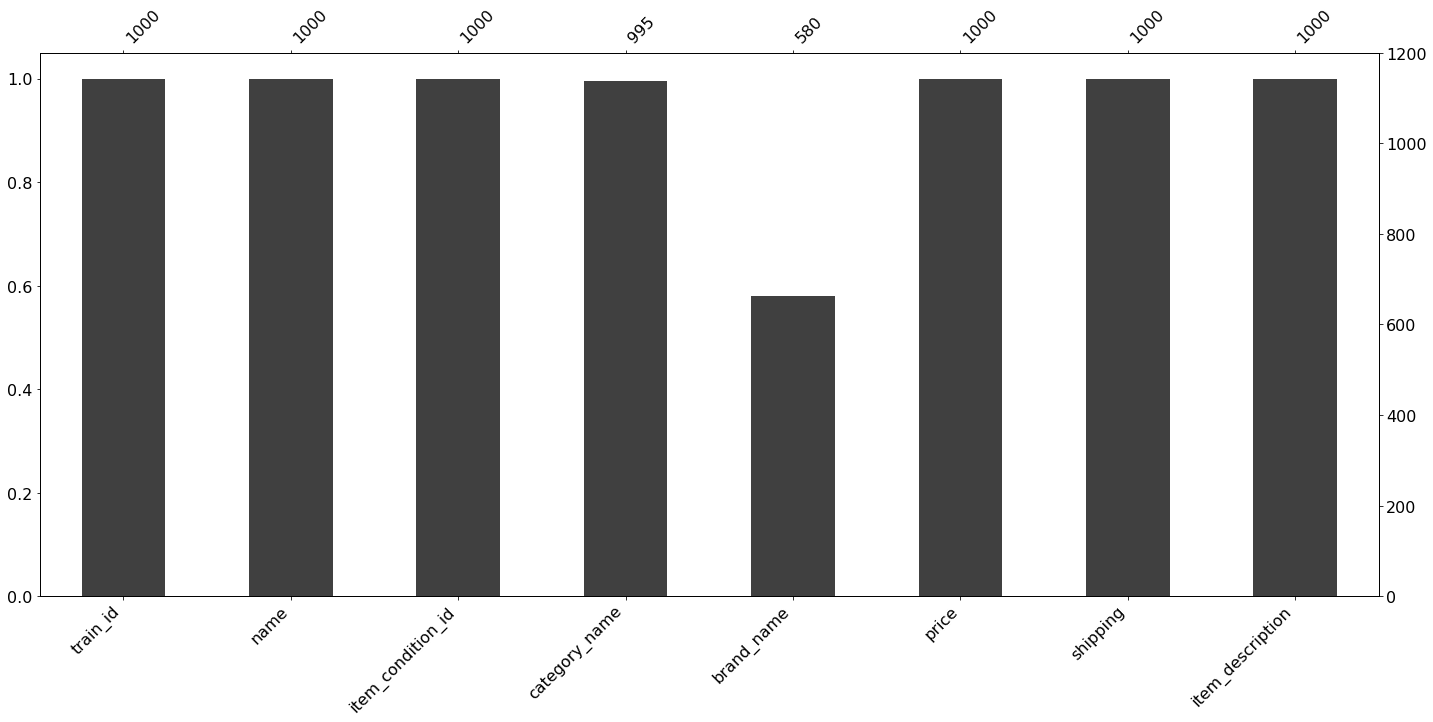

In [49]:
msno.bar(products.sample(1000))

The only two fields with null values are brand_name (~40% nulls) and category_name (0.3% nulls). This is helpful but doesn't tell us anything about the co-occurences missing data (i.e. when nulls occur in two different columns of the same row). For that we can use matrix.

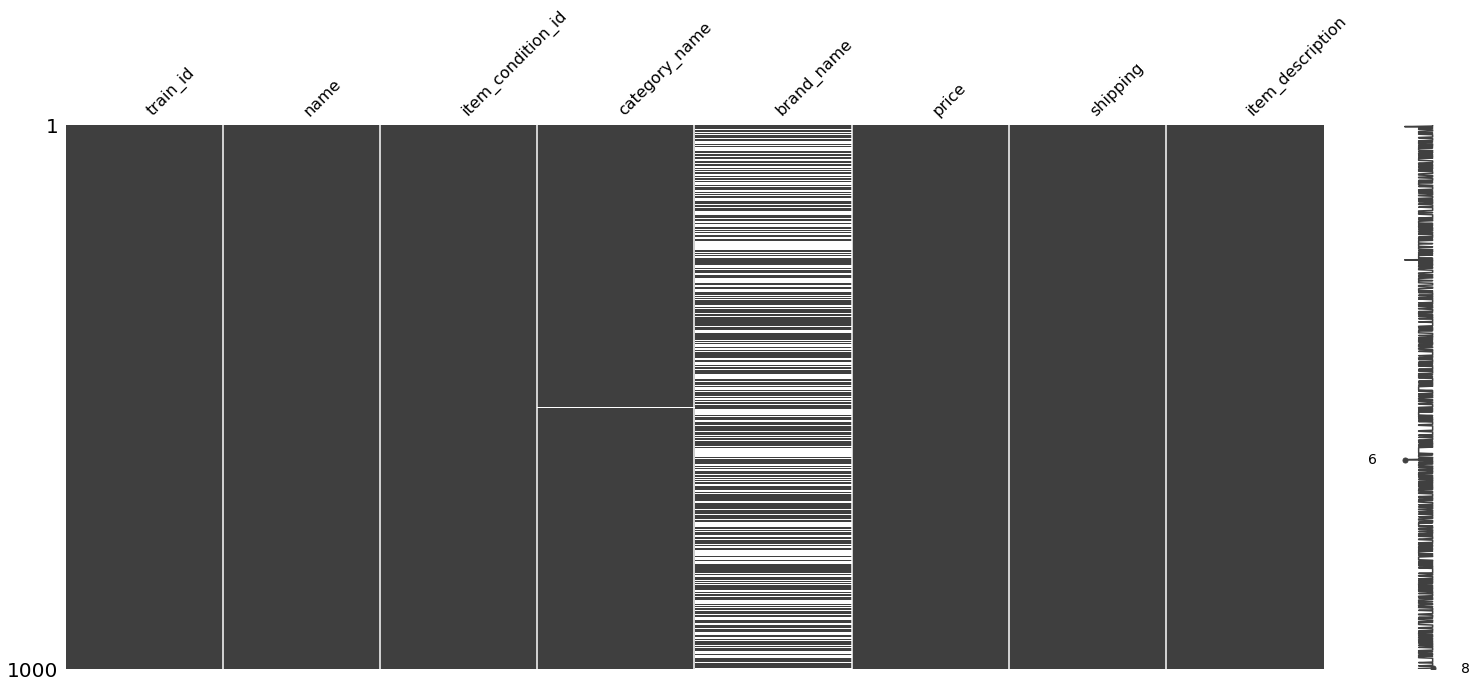

In [50]:
msno.matrix(products.sample(1000))

In the matrix view, the white areas represent missing data. It can be tricky to tell when the white areas line up exactly between columns. The spark line can help here. It tells you the trends of missing-ness including the mimimum number of non-null columns across all rows (6 in this example) an the maximum number of non-null columns across all rows (8 in this example).

# Data cleanup
Luckily for us, the data set is pretty clean, missing values are minimal, and overall the data set seems to be pretty high quality and consistently formatted. Still There are a few things we need to do to make the data easier to work with.

+ Fill in NA values
+ Get a sense for the format and see if any adjustments to the data are necessary
+ Break apart the category_name column
+ Convert category data to Pandas's category data type

## Fill in NA values
Pandas comes with a useful method fillna() for filling in misisng values. We provide the value we want to fill missing vlaues with as the first argument.

In [43]:
products["category_name_clean"] = products["category_name"].fillna("na")
products["item_description"] = products["item_description"].fillna("na")
products["brand_name"] = products["brand_name"].fillna("na")
products = products[products['price'] >0]

99.3% of the categories have 3 parts. This is good and means we can probably get by with just the first 3 parts of the category and ignore anything beyond that. Let's look at the lengths of names

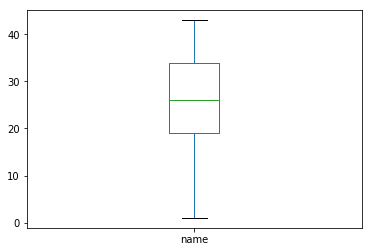

In [52]:
products.name.apply(lambda x: len(x)).plot(kind='box')

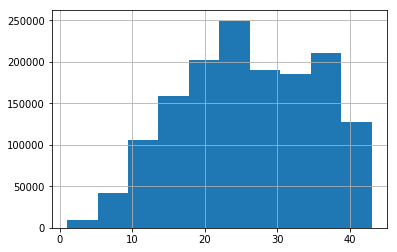

In [53]:
products.name.apply(lambda x: len(x)).hist()

The quartiles and distribution of name lengths look reasonable. Nothing too long, and no zero length strings.

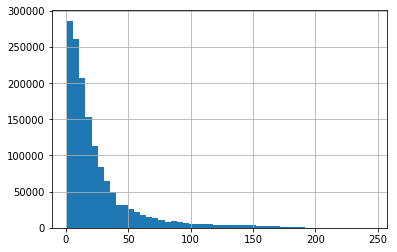

In [54]:
products.item_description.apply(lambda x: len(x.split(" "))).hist(bins = 50)

Distribution of description lengths looks reasonable with a large amount clustered around 0-20ish. Do we have any zero length descriptions?

In [55]:
mask = (products['item_description'].str.len() == 0)
products.loc[mask]

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description,category_name_clean


In [56]:
mask = (products['item_description'].str.len() < 5)
products.loc[mask]

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description,category_name_clean
58,58,New yokai watch backpack,1,Kids/Gear/Backpacks & Carriers,na,10.0,0,New,Kids/Gear/Backpacks & Carriers
140,140,Zelda Link Amiibo.,1,Electronics/Video Games & Consoles/Video Gamin...,Nintendo,40.0,1,New,Electronics/Video Games & Consoles/Video Gamin...
684,684,Splat Pink Fetish Rose Hair Dye,2,Beauty/Hair Care/Hair Color,na,7.0,0,Full,Beauty/Hair Care/Hair Color
768,768,Sale! [rm] For 2 morphe brushes,1,Beauty/Tools & Accessories/Makeup Brushes & Tools,na,12.0,1,New,Beauty/Tools & Accessories/Makeup Brushes & Tools
920,920,"Lularoe hula dancers, os.",1,"Women/Athletic Apparel/Pants, Tights, Leggings",na,30.0,1,New,"Women/Athletic Apparel/Pants, Tights, Leggings"
964,964,Doc McStuffins Activity Set Kit Toy,1,Kids/Toys/Dolls & Accessories,na,7.0,1,New,Kids/Toys/Dolls & Accessories
1253,1253,AF tank,2,"Women/Tops & Blouses/Tank, Cami",Abercrombie & Fitch,8.0,1,Nwot,"Women/Tops & Blouses/Tank, Cami"
1954,1954,Pom Pom keychain,1,Vintage & Collectibles/Accessories/Keychain,na,9.0,0,New,Vintage & Collectibles/Accessories/Keychain
1965,1965,"Burberry, baby boy, 18months",3,Kids/Boys 0-24 Mos/Tops & T-Shirts,na,22.0,0,Used,Kids/Boys 0-24 Mos/Tops & T-Shirts
1978,1978,LuLaRoe Sarah Large black thin ribbed,1,Women/Sweaters/Cardigan,na,86.0,0,BNWT,Women/Sweaters/Cardigan


No zero length descriptions, but a handful of descriptions with 1 word (or a small number). This probably won't matter too much, but is something we should look at more closely.

# Feature Engineering
In order to build model let's first make our data a little more model friendly

## Break apart the category name column
The category name column contains data in the format *"top level category/2nd level category/3rd level category"*. We could leave it like this, but breaking it apart by category level (i.e. one column for top level, 1 column for 2nd level, 1 column for 3rd level) could help us out by making it easy to split the data by category level (i.e. all "Womens" items). We'll write a function that extracts the nth level category and apply it to the cleaned category column from the previous cell

In [44]:
def get_cat_level(x, level):
    fields = x.split("/")
    if len(fields) >= level:
        return fields[level -1]
    else:
        return "na"

products["top_cat"] = products["category_name_clean"].apply(get_cat_level, args=(1,)).astype('category')
products["cat_2_name"] = products["category_name_clean"].apply(get_cat_level, args=(2,)).astype('category')
products["cat_3_name"] = products["category_name_clean"].apply(get_cat_level, args=(3,)).astype('category')
products["shipping"] = products["shipping"].astype('category')

# Convert category data to Pandas's category data type
We created the category level columns as categorical data, but there is one more step we need: to get category "codes" instead of the text names. This will come in handy later

In [5]:
products["shipping"] = products["shipping"].astype('category')
products["brand_name"] = products["brand_name"].astype('category')
products["top_cat_code"] = products.top_cat.cat.codes
products["cat_2_code"] = products.cat_2_name.cat.codes
products["cat_3_code"] = products.cat_3_name.cat.codes
products["brand_code"] = products.brand_name.cat.codes
products["shipping_code"] = products.shipping.cat.codes

In [18]:
products.head()

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description,category_name_clean,top_cat,cat_2_name,cat_3_name
0,0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,na,10.0,1,No description yet,Men/Tops/T-shirts,Men,Tops,T-shirts
1,1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,52.0,0,This keyboard is in great condition and works ...,Electronics/Computers & Tablets/Components & P...,Electronics,Computers & Tablets,Components & Parts
2,2,AVA-VIV Blouse,1,Women/Tops & Blouses/Blouse,Target,10.0,1,Adorable top with a hint of lace and a key hol...,Women/Tops & Blouses/Blouse,Women,Tops & Blouses,Blouse
3,3,Leather Horse Statues,1,Home/Home Décor/Home Décor Accents,na,35.0,1,New with tags. Leather horses. Retail for [rm]...,Home/Home Décor/Home Décor Accents,Home,Home Décor,Home Décor Accents
4,4,24K GOLD plated rose,1,Women/Jewelry/Necklaces,na,44.0,0,Complete with certificate of authenticity,Women/Jewelry/Necklaces,Women,Jewelry,Necklaces


In [45]:
products['description_length'] = products['item_description'].apply(lambda x: len(x.split(" ")))

# Explore relationships between predictors and responses
Ultimately our goal is to establish some kind of relationship between the predictors and the response variable so that we can make predictions. Let's start by exploring how responses vary across different input values using boxplots.

In [215]:
products['item_condition_id'].unique()

array([3, 1, 2, 4, 5])

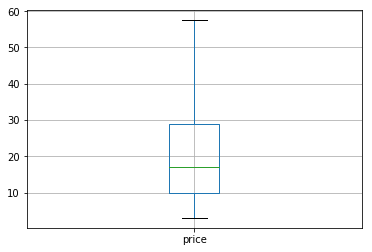

In [216]:
products.boxplot(column='price', showfliers=False)

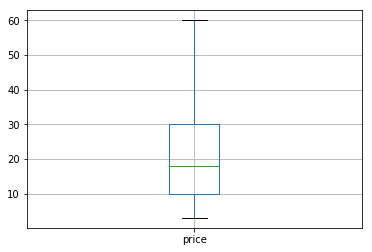

In [217]:
products[products['item_condition_id'] == 1].boxplot(column='price', showfliers=False)

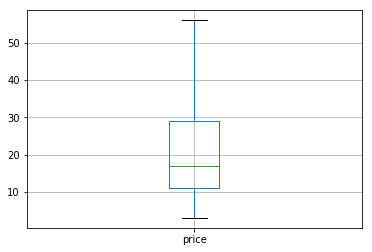

In [218]:
products[products['item_condition_id'] == 2].boxplot(column='price', showfliers=False)

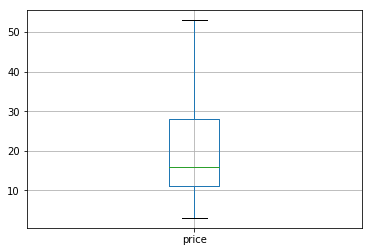

In [219]:
products[products['item_condition_id'] == 3].boxplot(column='price', showfliers=False)

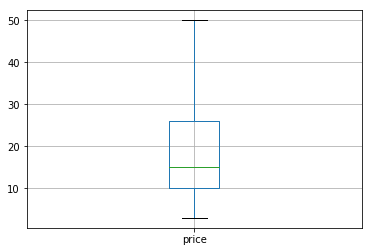

In [220]:
products[products['item_condition_id'] == 4].boxplot(column='price', showfliers=False)

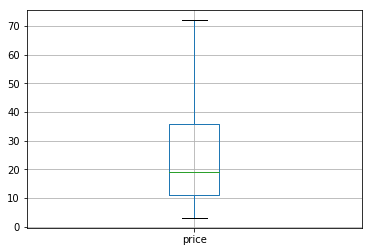

In [221]:
products[products['item_condition_id'] == 5].boxplot(column='price', showfliers=False)

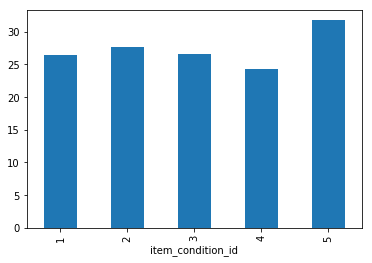

In [222]:
products.groupby(['item_condition_id']).mean()['price'].plot(kind='bar')

Boxplots show that there is a clear differences in the price between different item conditions. In particular, item conditions 1 and 5 tend to result in a higher price. Lets now look at how shipping method affects the price.

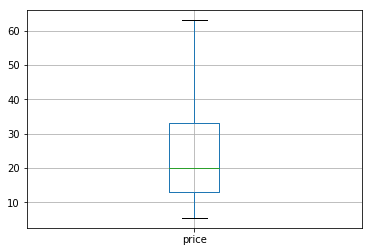

In [223]:
products[products['shipping'] == 0].boxplot(column='price', showfliers=False)

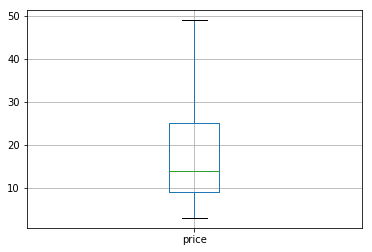

In [224]:
products[products['shipping'] == 1].boxplot(column='price', showfliers=False)

Again, prices tend to be higher when shipping = 0 (which means buyer pays shipping). This is a surprising result as we'd expect the opposite to be true i.e. when shipping is free, we'd expect buyers to pay a little more for the item.  Perhaps the price field includes shipping costs?

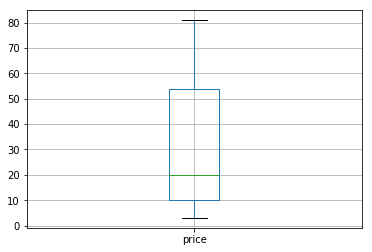

In [227]:
products[(products['brand_code'] == 3221)].boxplot(column='price', showfliers=False)

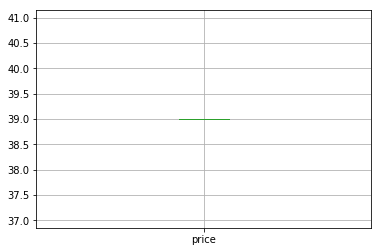

In [228]:
products[(products['brand_code'] == 3557)].boxplot(column='price', showfliers=False)

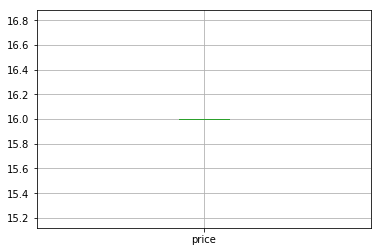

In [229]:
products[(products['brand_code'] == 2310)].boxplot(column='price', showfliers=False)

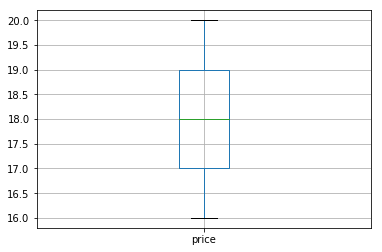

In [230]:
products[(products['brand_code'] == 4504)].boxplot(column='price', showfliers=False)

Again price varies with brand. Something to keep in mind when we build our model. Let's now look at the categories and how they impact the price, but this time instead of looking at individual boxplots, let's look at all the top level categories at once

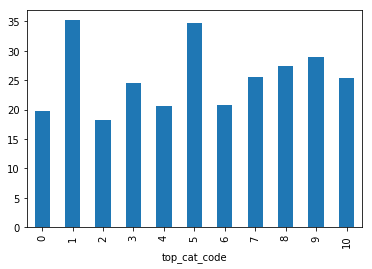

In [231]:
products.groupby(['top_cat_code']).mean()['price'].plot(kind='bar')

Again there are wide variations in average price between different categories. One last thing to look at is the relationship between the description length and the price

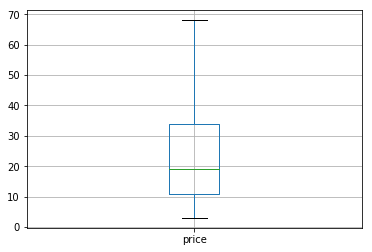

In [292]:
products[products['description_length'] == 45].boxplot(column='price', showfliers=False)

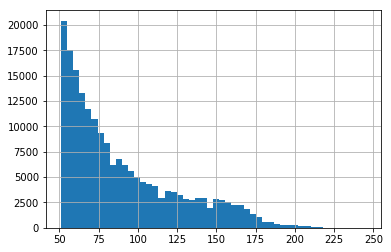

In [55]:
products[products['description_length'] > 50]['description_length'].hist(bins=50)

In [46]:
products['log_desc_length'] = products['description_length'].apply(lambda x: math.log(x))
products['log_price'] = products['price'].apply(lambda x: math.log(x) )

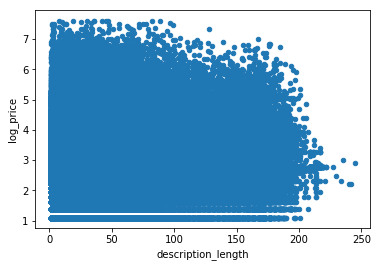

In [7]:
products[['description_length','log_price']].plot(kind='scatter', x='description_length', y='log_price')

We can see from the graph that shorter reviews tend to have higher prices. But variance depends on the description length. At this point we have a pretty rough sense of the relationship between several predictor variables and price. Now let's build a model using the predictors we just explored. But first we need to massage the data a bit more. In order to use categorical data in a mathematical model, we need to do something called one hot encoding. One hot encoding takes categorical data in a single column and converts it into a matrix with one column per categorical value. A row will have a '1' in the category column of any category it belongs to. Note that because there are so many brands we will limit to the top 200 brands in the data set (not including the 'na' brand).

In [64]:
mod = sm.OLS(products[products['price']>0].sample(100000, random_state=12).log_price.values.reshape(-1,1), sm.add_constant(products[products['price']>0].sample(100000, random_state=12).description_length.values.reshape(-1,1)))

In [65]:
res = mod.fit()

In [66]:
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     84.39
Date:                Sat, 10 Feb 2018   Prob (F-statistic):           4.14e-20
Time:                        17:05:05   Log-Likelihood:            -1.1841e+05
No. Observations:              100000   AIC:                         2.368e+05
Df Residuals:                   99998   BIC:                         2.368e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.8997      0.003    883.546      0.000       2.893       2.906
x1             0.0008   8.27e-05      9.186      0.000       0.001       0.001
==============================================================================
Omnibus:                     6055.291   Durbin-Watson:                   1.993
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             8097.019
Skew:                           0.561   Prob(JB):                         0.00
Kurtosis:                       3.827   Cond. No.                         52.1
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [200]:
import scipy
xt, lmbda = scipy.stats.boxcox(products[products['price']>0].sample(10000).price)

In [201]:
lmbda

-0.20671336033423826

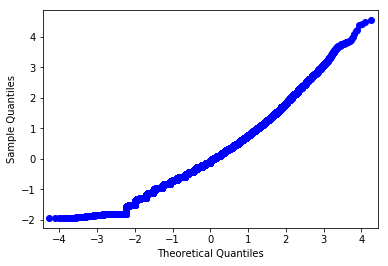

In [242]:
resids = res.resid
fig = sm.qqplot(resids)
plt.show()

In [ ]:
products[products['price']>0].sample(10000).log_price.quantile(0.1)

In [26]:
products[products['price'] > 0]['price'].as_matrix()

array([ 10.,  52.,  10., ...,  12.,  45.,  22.])

In [31]:
from scipy.stats import boxcox
boxcox_transform_price = boxcox(products[products['price'] > 0]['price'].as_matrix())

In [67]:
plt.scatter(boxcox_transform_price)
plt.title('Scatter plot pythonspot.com')
plt.show()

NameError: name 'boxcox_transform_price' is not defined

In [68]:
import gc
gc.collect()

340

In [30]:
'''
brands = products.brand_code.value_counts()[1:200].index.tolist()
third_cats = products.brand_code.value_counts()[1:200].index.tolist()

ohe = OneHotEncoder()
ohe.fit(products.top_cat_code.values.reshape(-1,1))  

ohe2 = OneHotEncoder(handle_unknown='ignore')
ohe2.fit(np.array(brands).reshape(-1,1))

ohe3 = OneHotEncoder()
ohe3.fit(products.cat_2_code.values.reshape(-1,1))
'''
ohe4 = OneHotEncoder()
ohe4.fit(products.item_condition_id.values.reshape(-1,1))
'''
ohe5 = OneHotEncoder()
ohe5.fit(products.cat_3_code.values.reshape(-1,1))

ohe6 = OneHotEncoder()
ohe6.fit(products.shipping_code.values.reshape(-1,1))
'''
item_cond_id = ohe4.transform(products.item_condition_id.values.reshape(-1,1)).toarray()
'''
ohe_sub_cat = ohe3.transform(products.cat_2_code.values.reshape(-1,1)).toarray()
ohe_cat = ohe.transform(products.top_cat_code.values.reshape(-1,1)).toarray()
ohe_brand_code = ohe2.transform(products.brand_code.values.reshape(-1,1)).toarray()
ohe_third_cat = ohe5.transform(products.cat_3_code.values.reshape(-1,1)).toarray()
shipping_code = ohe6.transform(products.shipping_code.values.reshape(-1,1)).toarray()
'''

'\nohe_sub_cat = ohe3.transform(products.cat_2_code.values.reshape(-1,1)).toarray()\nohe_cat = ohe.transform(products.top_cat_code.values.reshape(-1,1)).toarray()\nohe_brand_code = ohe2.transform(products.brand_code.values.reshape(-1,1)).toarray()\nohe_third_cat = ohe5.transform(products.cat_3_code.values.reshape(-1,1)).toarray()\nshipping_code = ohe6.transform(products.shipping_code.values.reshape(-1,1)).toarray()\n'

In [47]:
not_top_brands = products['brand_name'].value_counts()[300:]
products['brand_name'] = products['brand_name'].replace(not_top_brands.index, "na")
not_top_cats = products['category_name_clean'].value_counts()[300:]
products['category_name_clean'] = products['category_name_clean'].replace(not_top_cats.index, "na")

In [48]:
products = pd.get_dummies(products, 
                          columns=['brand_name',
                                   'category_name_clean',
                                   'shipping',
                                   'top_cat',
                                   'item_condition_id'])

# A simple linear model
Now lets try an build a simple model to predict the price based on some of the predictors we've explored above. What kind of model do we choose?  Linear models are a great general purpose tool, but only work well under a certain set of assumptions, mainly:
- continuous variables
- that the predictors have a linear relationship with the predictor
- the residuals are normally distributed
- the variance of the errors doesn't change with the value of the predictors
- our input features aren't collinear (this one isn't strictly necessary, but usually preferred)

Several of these assumptions and don't appear to hold for our data set...
Many of our predictors are categorical in nature (shipping type, condition, product category). There does not appear to be a linear relationship between review length, our only continuous variable, and the price. The residuals of a OLS fit would not be normally distributed or have a consistent variance. On the other hand, it does seem like splitting the data and predicting averages *might* get us somewhere. So let's try a regression tree and compare it's performance to an OLS fit linear regression. Note that the linear regression will have low variance but high bias. In other words it might not be able to capture the true relationship very well, but it *will* be consistent in the models it produces based on different samples of the data. On the other hand, the regression tree with have low bias but high variance, meaning it will be a bit better at capturing the relationship, but the model we end up with will depend heavily on what data we train it on. We will revisit how choose the best model later but for now, it's good to understand the characteristics of our model choices.

## R^2

Let's fit our models with brand, item condition, shipping value, and description length. We will use the R^2 coefficient to evaluate the model. R^2 tells us how much of the variation is described by our model. One way to make a predictive model is to just predict the average value of your training set. The problem with this is that if your data has a non-zero variance (i.e. points are dispersed about the mean), the model will do a poor job in predicting these points which don't lie on the mean. What R^2 tells you is what % of the total variation DOES the model predict. It tells you how much better your model is than just predicting the mean value of the data.

In [63]:
mod = sm.OLS(products['log_price'], sm.add_constant(products['description_length']))
res = mod.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              log_price   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     1289.
Date:                Sat, 10 Feb 2018   Prob (F-statistic):          3.20e-282
Time:                        21:50:40   Log-Likelihood:            -1.7505e+06
No. Observations:             1481661   AIC:                         3.501e+06
Df Residuals:                 1481659   BIC:                         3.501e+06
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  2.8933      0.001   3410.536      0.000       2.892       2.895
description_length     0.0008   2.13e-05     35.907      0.000       0.001       0.001
==============================================================================
Omnibus:                    88561.349   Durbin-Watson:                   2.002
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           118078.948
Skew:                           0.557   Prob(JB):                         0.00
Kurtosis:                       3.819   Cond. No.                         52.1
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [49]:
cols = [col for col in products.columns if col.startswith('top_cat_') or col.startswith('item_condition_id_') or col.startswith('shipping_') or col.startswith('brand_name_') or col.startswith('category_name_clean_') or col == "description_length"]

In [50]:
mod = sm.OLS(products['log_price'].as_matrix().reshape(-1,1), 
             sm.add_constant(products[cols]).as_matrix().reshape(len(products),-1))
res = mod.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.385
Model:                            OLS   Adj. R-squared:                  0.384
Method:                 Least Squares   F-statistic:                     1508.
Date:                Sun, 11 Feb 2018   Prob (F-statistic):               0.00
Time:                        02:20:55   Log-Likelihood:            -1.3914e+06
No. Observations:             1481661   AIC:                         2.784e+06
Df Residuals:                 1481046   BIC:                         2.792e+06
Df Model:                         614                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.4884      0.002    766.662      0.000       1.485       1.492
x1             0.0019   1.76e-05    110.631      0.000       0.002       0.002
x2             0.1899      0.032      5.863      0.000       0.126       0.253
x3            -0.2278      0.025     -9.054      0.000      -0.277      -0.178
x4             0.2497      0.015     16.382      0.000       0.220       0.280
x5            -0.3328      0.027    -12.493      0.000      -0.385      -0.281
x6            -0.1326      0.032     -4.141      0.000      -0.195      -0.070
x7            -0.3069      0.011    -27.470      0.000      -0.329      -0.285
x8             1.1028      0.029     37.411      0.000       1.045       1.161
x9            -0.0103      0.007     -1.565      0.118      -0.023       0.003
x10           -0.5707      0.013    -42.517      0.000      -0.597      -0.544
x11            0.0962      0.029      3.356      0.001       0.040       0.152
x12            0.5440      0.012     46.551      0.000       0.521       0.567
x13            0.1541      0.033      4.738      0.000       0.090       0.218
x14           -0.0018      0.029     -0.063      0.950      -0.059       0.055
x15           -0.0613      0.015     -3.973      0.000      -0.092      -0.031
x16            0.3551      0.014     24.637      0.000       0.327       0.383
x17           -0.3151      0.006    -53.988      0.000      -0.327      -0.304
x18            0.3295      0.016     20.663      0.000       0.298       0.361
x19            0.1158      0.013      8.884      0.000       0.090       0.141
x20           -0.3458      0.019    -18.047      0.000      -0.383      -0.308
x21            0.1331      0.020      6.551      0.000       0.093       0.173
x22            0.3872      0.006     64.132      0.000       0.375       0.399
x23           -0.3352      0.036     -9.237      0.000      -0.406      -0.264
x24            0.3553      0.036      9.837      0.000       0.284       0.426
x25           -0.0478      0.025     -1.944      0.052      -0.096       0.000
x26           -0.5091      0.021    -24.814      0.000      -0.549      -0.469
x27           -0.0333      0.036     -0.925      0.355      -0.104       0.037
x28           -0.5801      0.031    -18.935      0.000      -0.640      -0.520
x29           -0.0313      0.032     -0.980      0.327      -0.094       0.031
x30           -0.2961      0.018    -16.213      0.000      -0.332      -0.260
x31            0.9467      0.031     30.077      0.000       0.885       1.008
x32           -0.2251      0.019    -11.905      0.000      -0.262      -0.188
x33           -0.0969      0.026     -3.701      0.000      -0.148      -0.046
x34           -0.2122      0.007    -29.143      0.000      -0.227      -0.198
x35            1.2788      0.020     65.033      0.000       1.240       1.317
x3

R^2 = .247 is not the strongest result. Further, we haven't checked for collinearity, which could negatively impact our results. Also, our linear model has high bias, meaning it is not able to capture the true relationship between the predictors and the response variable. We could address some of these problems (i.e. choosing variables that aren't collinear), but the bias issue will remain and there doesn't appear to be a linear relationship between our predictors and our response variable so a linear model may not even be a good choice. Let's try a model with lower bias, the regression tree. Regression trees are a very powerful modeling technique and tend to have lower bias, but higher variance (meaning they are very sensitive to changes in the training data). Regression trees work by evaluating each predictor variable, choosing the split that results in the lowest training error, and repeating until there are no more variables to split on. Let's build a tree based on the same three variables that we built our linear regression on.

In [51]:
tree = DecisionTreeRegressor(random_state=0)
tree.fit(products[cols], products['log_price'])
tree.score(products[cols], products['log_price'])

0.62149934275869356

Our hypothesis was right! A regression tree does a better job at predicting the price than a linear model! Or does it? Recall that trees have higher variance, meaning the model you end up with depends to a large degree on the data you've trained on. So the tree might be *really* good at recognizing the data set it was trained on, but it may generalize poorly to new data it hasn't seen before. How can we detect this? Well we cannot measure variance directly, as this depends on knowing the true function (and if we knew that we wouldn't be bothering with modeling in the first place!). Instead we will use an indirect measurement: We will to cross validation. 

# Cross Validation
Cross validation means that we will divide the training data into k sets and do k rounds of training. Each round we will train on k-1 of the sets, then validate the performance of the model on the 1 set that the model did not train on (our validation set). If our variance is high (meaning we are overfitting to the training set) we should see model perform much better on the training set than the validation set. Sklearn provides a function to do cross-validation for us.

In [ ]:
cross_val_score(tree, products[cols], products['log_price'], cv=10)

Let's re-create the linear model as sklearn's LinearRegression model so that we can do CV on it and compare to our tree

In [73]:
linear_model = LinearRegression()
linear_model.fit(products[cols], products['log_price'])
linear_model.score(products[cols], products['log_price'])

0.24719224302643492

In [76]:
cross_val_score(linear_model, products[cols], products['log_price'],cv=10)

array([ 0.24796805,  0.24098774,  0.24629472,  0.25005914,  0.24575196,
        0.24835504,  0.24920396,  0.24551633,  0.24919156,  0.24660189])

Our regression tree model is a little better than our linear model at predicting prices AND that it's predictive ability generalizes well to unseen data. It is overfitting to the training set, but this is expected as trees have high variance

In [56]:
msk = np.random.rand(len(products)) < 0.8

train = products[msk]
valid = products[~msk]

In [16]:
from sklearn import model_selection
x_train, x_valid, y_train, y_valid = model_selection.train_test_split(
    products[cols], 
    products['log_price'], 
    test_size=0.2)

dtrain = xgboost.DMatrix(x_train, y_train)
dvalid  = xgboost.DMatrix(x_valid,  y_valid)
watchlist = [(dtrain, 'train'), (dvalid, 'valid')]
params = {'max_depth': 30, 'nthread': 4, 'reg_lambda' : 1, 'colsample_bytree': .9, 'subsample' : .8, 'booster' : 'gbtree', 'silent': 1, 'eval_metric': 'rmse', 'objective': 'reg:linear'}

In [94]:
model = xgboost.train(params, dtrain, 1000, watchlist, verbose_eval=10, early_stopping_rounds=50)

[0]	train-rmse:1.84239	valid-rmse:1.84505
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[10]	train-rmse:0.653664	valid-rmse:0.67111
[20]	train-rmse:0.645235	valid-rmse:0.668069
[30]	train-rmse:0.641884	valid-rmse:0.668412
[40]	train-rmse:0.638231	valid-rmse:0.670181
[50]	train-rmse:0.635392	valid-rmse:0.672323
[60]	train-rmse:0.633024	valid-rmse:0.6753
[70]	train-rmse:0.631794	valid-rmse:0.677389
Stopping. Best iteration:
[21]	train-rmse:0.645115	valid-rmse:0.667961



In [95]:
xgb_preds = model.predict(dtrain)

In [20]:
def coeff_determination(dm_true, dm_pred):
    SS_res = np.sum(np.square( dm_true.get_label() - dm_pred))
    SS_tot = np.sum(np.square(dm_true.get_label() - np.mean(dm_pred)))
    return (1-SS_res/SS_tot)

def coeff_determination2(dm_pred, dtrain):
    SS_res = np.sum(np.square(dtrain.get_label() - dm_pred))
    SS_tot = np.sum(np.square(dtrain.get_label() - np.mean(dm_pred)))
    return 'R^2',(1-SS_res/SS_tot)

In [97]:
coeff_determination(dtrain, xgb_preds)

0.35851812362670898

In [21]:
x = xgboost.DMatrix(products[cols],
                   label = products['log_price'])
cv = xgboost.cv(params, x, 100, nfold=5,early_stopping_rounds=25,verbose_eval=1,feval=coeff_determination2)

[0]	train-R^2:0.022339+4.52637e-05	test-R^2:0.0220952+0.00014926
[1]	train-R^2:0.0586434+0.000358661	test-R^2:0.0577232+0.000518965
[2]	train-R^2:0.108349+0.000447937	test-R^2:0.105754+0.000732603
[3]	train-R^2:0.162146+0.00118475	test-R^2:0.156401+0.00100869
[4]	train-R^2:0.209156+0.00114285	test-R^2:0.198574+0.00131883
[5]	train-R^2:0.243042+0.00263178	test-R^2:0.227049+0.00121858
[6]	train-R^2:0.265044+0.00238949	test-R^2:0.243563+0.00100874
[7]	train-R^2:0.279215+0.00179748	test-R^2:0.252162+0.00116244
[8]	train-R^2:0.288115+0.00139072	test-R^2:0.25622+0.00140018
[9]	train-R^2:0.293836+0.00112518	test-R^2:0.257637+0.0014796
[10]	train-R^2:0.297257+0.000880007	test-R^2:0.258174+0.00151413
[11]	train-R^2:0.299752+0.00107861	test-R^2:0.258021+0.00165649
[12]	train-R^2:0.301432+0.000762836	test-R^2:0.257875+0.00178414
[13]	train-R^2:0.302897+0.000878334	test-R^2:0.257454+0.00197511
[14]	train-R^2:0.304146+0.00078766	test-R^2:0.257034+0.0020493
[15]	train-R^2:0.304838+0.000809577	test-R

In [157]:
tfidf = TfidfVectorizer(stop_words="english", max_features=1000, ngram_range=(1, 3))

In [158]:
tfidf.fit(products['name'])

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=1000, min_df=1,
        ngram_range=(1, 3), norm='l2', preprocessor=None, smooth_idf=True,
        stop_words='english', strip_accents=None, sublinear_tf=False,
        token_pattern='(?u)\\b\\w\\w+\\b', tokenizer=None, use_idf=True,
        vocabulary=None)

In [159]:
t = tfidf.transform(products['name'])

In [144]:
t

<1481661x1000 sparse matrix of type '<class 'numpy.float64'>'
	with 4104751 stored elements in Compressed Sparse Row format>

In [126]:
np.array(t[:,800].todense().tolist()).reshape(-1,)[msk]

array([ 0.60930498,  0.78955982,  0.50799398, ...,  0.26318066,
        0.26102125,  0.28402927])

In [92]:
np.argmax(tfidf.idf_)

894

In [170]:
tfidf.get_feature_names()[41]

'air jordan'

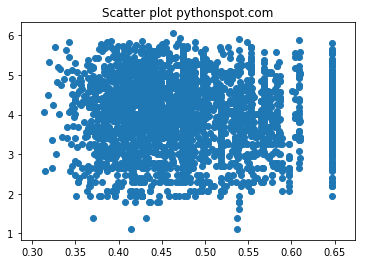

In [171]:
#msk = (np.array(t[:,489].todense().tolist()).reshape(-1,) > .33) & (np.array(t[:,489].todense().tolist()).reshape(-1,) < .39)
msk = (np.array(t[:,41].todense().tolist()).reshape(-1,) > 0)
plt.scatter(np.array(t[:,41].todense().tolist()).reshape(-1,)[msk],products['log_price'][msk])
plt.title('Scatter plot pythonspot.com')
plt.show()

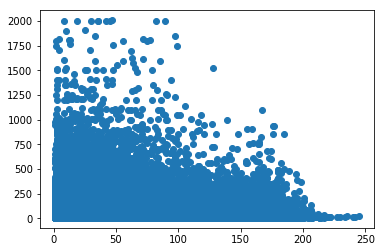

In [112]:
plt.scatter(products['description_length'],products['price'])
plt.show()